# Markowitz Portfolio Optimization
The path-breaking insight of Markowitz was that the risk/return profiles of single assets should not be viewed separately but in their porfolio context. In this respect, portfolios are considered to be efficient if they are either risk minimal for a given return level or have the maximum return for a given level of risk. Even though both views of efficient portfolios are equivalent, the kind of portfolio optimization does differ for these two cases. The former is a **quadaratic optimization with linear constraints, whereas in the latter the objective function is linear and the constraints are quadratic**  
   
### Assumptions:   
Assuming that there are $N$ assets and that these are infinitely divisible. The returns of these assets are jointly normally distributed.   
  

## 1. Some definitions
### 1.1 Return, rate of return of assets
An investment instrument that can be bought and sold is often called an asset. Suppose we purchase ans asset for $x_0$ dollars on one date and later sell it for $x_1$ dollars.  
$$ \text{return:  } R = \frac{x_1}{x_0} $$ 
$$ \text{rate of return:  } r = R - 1 = \frac{x_1 - x_0}{x_0}$$ 
  
### 1.2 Weight 
$w_i$ is a weighting factor for asset i. Noting that we allow the weights to take negative values and when negative it means that the asset is being shorted in our portfolio.  
 
### 1.3 Rate of return on the portfolio:  
$$ r = R- 1 = \displaystyle\sum_{i=1}^n r_iw_i$$ 

## 2. The Basics of Markowitz Mean-Variance Portforlio Theory 
### 2.1 Assumptions 
1. One models the rate of returns on assets as random variables. 
2. There does not exit any asset that is a combination of other assets in the portfolio, iie non existence of redundant security. 


The goal is then to choose the portfolio weighting factors optionally.  An **optimal set of weights is one in which the portforlio achieves an acceptable baseline expected rate of return with minimal volatility.**  
  
$r_i$ is the random variable associated with the rate of return for asset i, for i= 1,2...,n and 
$$z = 
\begin{pmatrix} 
r_1 \\
r_2 \\ 
\vdots \\ 
r_n 
\end{pmatrix}$$  
$\mu_i = E(r_i)$   
$w = (w_1,w_2...,w_n)^T$ is a set of weights associated with a poftfolio   
$\sum = cov(z)$ matrix of covariance-variance;
$ r = \displaystyle\sum_{i=1}^n r_iw_i$ is the rate of return of this portfolio, random variable with mean $m^Tw$ and variance $w^T\sum w$

if $\mu_b$ is the acceptable baseline expected rate of return, Markowitz portfolio Optimization problem becomes the following quadratic program:  
$$ 
\begin{eqnarray} min \frac{1}{2} w^T \Sigma w  \\
\text{subject to:  }~~~ m^Tw = \mu_b  \\ 
e^Tw = 1
\end{eqnarray}
$$
with e denotes the vector of ones   
  
We form the Lagrangian

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [4]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)
print(return_vec)

[[-1.0856306   0.99734545  0.2829785  ..., -0.90932702  0.47026375
  -1.11143045]
 [-0.74882747  0.56759473  0.71815054 ..., -0.35929672 -1.60969508
   0.01357006]
 [-1.77422355 -1.20137731  1.09625679 ...,  2.04043199  1.01591697
  -1.63378817]
 [-0.45059869  0.60959032  1.17374438 ..., -0.1227329   1.79448602
  -0.32050951]]


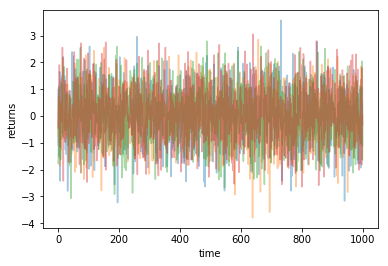

In [5]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [6]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(n_assets)

[ 0.54066805  0.2360283   0.11660484  0.1066988 ]


Lets evaluate how many of these random portfolios would perform. Towards this goal we are calculating the mean returns as well as the volatility (here we are using standard deviation)   
Expected return is calculated as the weighted average of the likely profits of the assets in the portfolio, weighted by the likely profits of each asset class


In [7]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    m = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * m.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

Lets generate the mean returns and volatility for 500 random portfolios:

In [8]:
n_portfolios = 500 
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])

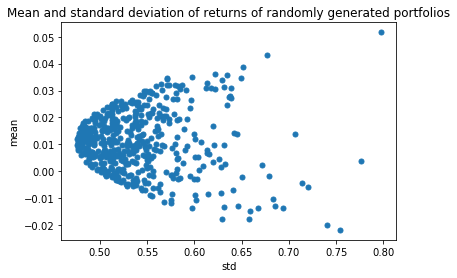

In [9]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

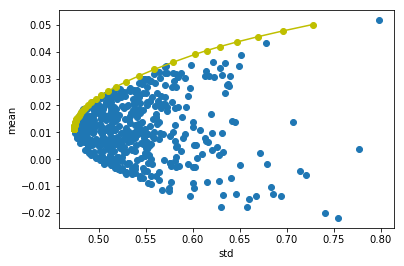

In [10]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')